In [1]:
%matplotlib inline


迁移学习
==========================
**Author**: `Sasank Chilamkurthy`https://chsasank.github.io

在本教程中，将学习如何使用转移学习训练自己的网络。 你可以阅读更多关于转移学习的内容在[cs231n notes](http://cs231n.github.io/transfer-learning/)

引用这些笔记：
> 在实践中，很少有人从头开始训练整个卷积神经网络(用随机初始化)，因为拥有足够大小的数据集是相对少见的。相反，在一个非常大的数据集上预先训练     一个ConvNet是很常见的。 (例如ImageNet包含了120万张有1000个类别的图片)，然后使用卷积神经网络作为初始化或固定的特征提取器来完成感兴趣的任     务。
 
两种主要的迁移学习情景如下：

-  **微调convnet**： 我们使用预先训练的网络来初始化网络，就像在imagenet 1000数据集上训练的那样，而不是随机初始化。剩下的训练过程看和往常一样。
-  **ConvNet作为固定特征提取器**：在这里，我们将冻结所有网络的权重，除了最后一个全连接层。最后一个全连接层被替换为一个带有随机权重的新层，只有这一层被训练。




In [7]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # 交互模式

加载数据
---------

使用torchvision和torch.utils.data包加载数据。

我们今天要解决的问题是训练一个模型来分类**蚂蚁** and **蜜蜂**。我们为蚂蚁和蜜蜂准备了大约120张训练图片。每个类有75个验证图像。如果是从头训练的话，这是一个非常小的数据集。既然使用的是转移学习，我们就应该能够很好的泛化。

这个数据集是imagenet的一个非常小的子集。从[这里](https://download.pytorch.org/tutorial/hymenoptera_data.zip)下载数据，然后解压到当前目录。



In [8]:
# 数据扩增和归一化
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 可视化一些图像

让我们可视化一些训练图像，以便理解数据增强。



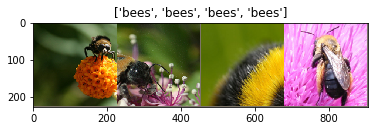

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

训练模型
------------------

现在，写一个通用函数来训练一个模型。

-  设置学习速率
-  保存最好的模型

在下面，参数 ``scheduler``是``torch.optim.lr_scheduler``的一个LR调度器对象


In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## 可视化模型预测

泛型函数展示一些图像的预测




In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

微调convnet
----------------------

加载一个预先训练的模型，并重新设置最后的全连接层。




In [12]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/tina/.torch/models/resnet18-5c106cde.pth
100.0%


## 训练和评估


它应该在CPU上花费大约15到25分钟。不过，在GPU上，它的花费还不到一分钟。




In [13]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6175 Acc: 0.6762
val Loss: 0.2698 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.7347 Acc: 0.7418
val Loss: 0.2626 Acc: 0.8889

Epoch 2/24
----------
train Loss: 0.4919 Acc: 0.7869
val Loss: 0.3937 Acc: 0.8301

Epoch 3/24
----------
train Loss: 0.5585 Acc: 0.7951
val Loss: 0.4033 Acc: 0.8758

Epoch 4/24
----------
train Loss: 0.5532 Acc: 0.8115
val Loss: 0.1861 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.5734 Acc: 0.7664
val Loss: 0.2745 Acc: 0.9020

Epoch 6/24
----------
train Loss: 0.5920 Acc: 0.7992
val Loss: 0.2668 Acc: 0.8954

Epoch 7/24
----------
train Loss: 0.3656 Acc: 0.8525
val Loss: 0.2541 Acc: 0.9020

Epoch 8/24
----------
train Loss: 0.2907 Acc: 0.8566
val Loss: 0.2127 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.2825 Acc: 0.8934
val Loss: 0.2048 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.3368 Acc: 0.8402
val Loss: 0.2266 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.2709 Acc: 0.8811
val Loss: 0.2035 Acc: 0.9346

Ep

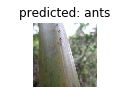

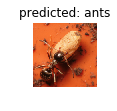

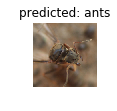

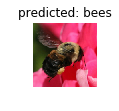

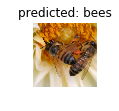

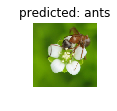

In [14]:
visualize_model(model_ft)

ConvNet作为固定的特征提取器
----------------------------------

在这里，除了最后一层，我们需要冻结所有的网络。我们需要设置``requires_grad == False``将参数冻结，这样``backward()``中梯度就不会被计算。

你可以在文档中了解[更多信息](http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward)




In [15]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# 新构造的模块的参数在默认情况下是requires_grad=True
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

## 训练和评估

在CPU上，这将花费大约一半的时间与以前的场景相比。这是意料之中的，因为网络中大部分都不需要计算梯度。然而，需要计算前向传播。



In [16]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7770 Acc: 0.6230
val Loss: 0.2022 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.4624 Acc: 0.7828
val Loss: 0.2728 Acc: 0.8954

Epoch 2/24
----------
train Loss: 0.9696 Acc: 0.6434
val Loss: 0.1640 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.7185 Acc: 0.7459
val Loss: 0.1758 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.5889 Acc: 0.7664
val Loss: 0.2748 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.4984 Acc: 0.8156
val Loss: 0.1574 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.4601 Acc: 0.7951
val Loss: 0.1966 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.4016 Acc: 0.8279
val Loss: 0.1696 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.2931 Acc: 0.8770
val Loss: 0.1695 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3116 Acc: 0.8525
val Loss: 0.1933 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.4355 Acc: 0.8074
val Loss: 0.1727 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3952 Acc: 0.8525
val Loss: 0.1677 Acc: 0.9412

Ep

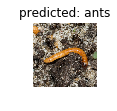

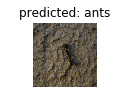

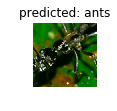

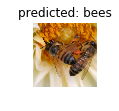

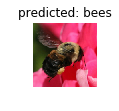

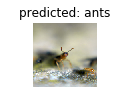

In [17]:
visualize_model(model_conv)

plt.ioff()
plt.show()